# Q2
In this question, the main focus is to analyze how external factors influence fresh fruit bunch (FFB) yield. We will perform descriptive and exploratory analysis to understand our datasets. Then, we will use two explainable machine learning models namely Linear Regression and Decision Tree to analyze the relationship between external factors and FFB yield. The main steps to solve Q2:
- A. Import libraries and read dataset
- B. Descriptive analysis
- C. Exploratory analysis
- D. Linear Regression
- E. Decision Tree

A short summary is provided in the end of each section to summarize the findings.

## A. Import libraries and read dataset

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import f1_score

In [2]:
# Read dataset and show first 5 rows
data = pd.read_csv("data/palm_ffb.csv")
data.head()

,Date,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
0,01.01.2008,616.4,25.306452,21.3,32.2,184.4,25,777778.3951,1.62
1,01.02.2008,568.9,26.165517,20.9,35.1,140.2,23,767988.2759,1.45
2,01.03.2008,577.6,25.448387,21.3,32.9,280.4,25,783951.9231,1.56
3,01.04.2008,581.1,26.903333,20.6,34.8,173.3,25,788987.0504,1.39
4,01.05.2008,545.4,27.241935,20.9,35.0,140.6,25,813659.7222,1.44


### Summary:
This dataset consists of monthly record of FFB yield and the external factors. Date is not important in this study, we will remove it.

## B. Descriptive analysis

In [3]:
# Check number of duplicated rows
data.duplicated().sum()

0

In [4]:
# Drop Date
data.drop("Date", axis=1, inplace=True)

In [5]:
# Get basic info of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SoilMoisture   130 non-null    float64
 1   Average_Temp   130 non-null    float64
 2   Min_Temp       130 non-null    float64
 3   Max_Temp       130 non-null    float64
 4   Precipitation  130 non-null    float64
 5   Working_days   130 non-null    int64  
 6   HA_Harvested   130 non-null    float64
 7   FFB_Yield      130 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 8.2 KB


In [6]:
# Get statistics of each attribute
data.describe()

,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,527.646923,26.849918,21.379231,33.851538,188.980769,24.753846,793404.491565,1.602231
std,57.367844,0.651413,0.688971,1.079638,80.237210,1.239289,34440.893854,0.281751
min,380.700000,25.158065,18.900000,31.100000,2.000000,21.000000,683431.944400,1.080000
25%,488.625000,26.442285,21.000000,33.100000,140.300000,24.000000,768966.949100,1.390000
50%,538.300000,26.930645,21.500000,33.900000,182.150000,25.000000,790036.158050,1.585000
75%,571.025000,27.270726,21.800000,34.600000,226.100000,26.000000,821989.235250,1.807500
max,647.300000,28.580000,22.600000,36.000000,496.100000,27.000000,882254.225400,2.270000


### Summary:
After dropping attribute Date, the dataset has 130 rows and 8 columns. All columns are of numerical attributes, no missing value and duplicates in the dataset. The statistics of each attribute are shown in the table above. From the tables, we can see that mean and median of these attributes are roughly the same, they are most probrably following normal distribution, will need to examine it further.

## C. Exploratory analysis

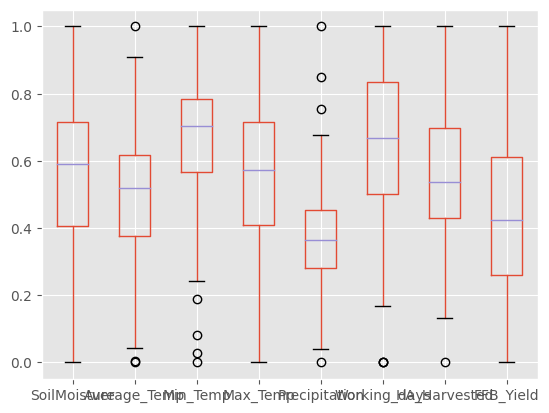

In [7]:
# Detect outliers using boxplot
scaler = MinMaxScaler().fit(data)
scaled_data = pd.DataFrame(scaler.transform(data), columns=data.columns)
plt.style.use("ggplot")
scaled_data.boxplot()
plt.show()

In [8]:
# Remove outliers: only keep rows that have values within 1.5*IQR of Q1 and Q3
Q1 = data.quantile(q=0.25)
Q3 = data.quantile(q=0.75)
IQR = data.apply(stats.iqr)
data = data[~((data < (Q1-1.5*IQR)) | (data > (Q3+1.5*IQR))).any(axis=1)]

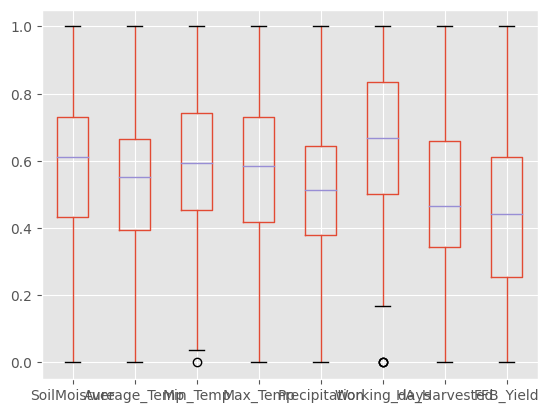

In [9]:
# Detect outliers using boxplot again
scaler = MinMaxScaler().fit(data)
scaled_data = pd.DataFrame(scaler.transform(data), columns=data.columns)
scaled_data.boxplot()
plt.show()

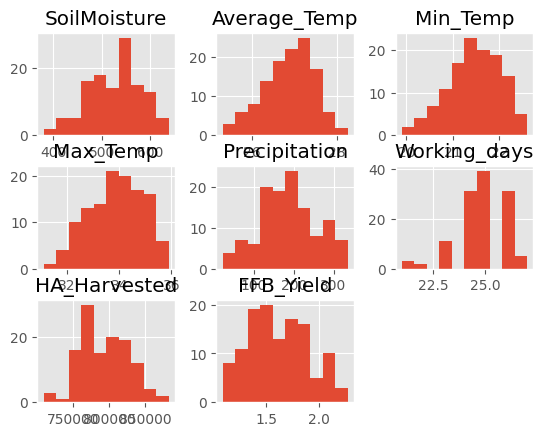

In [10]:
# Check the distribution of each attribute using histogram
data.hist()
plt.show()

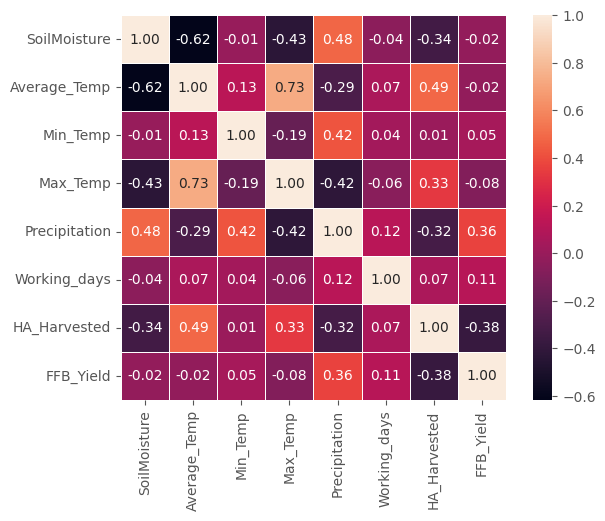

In [11]:
# Check correlation between attributes using heatmap
corr = data.corr()
f, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(corr, square=True, annot=True, fmt=".2f", linewidths=.5)
plt.show()

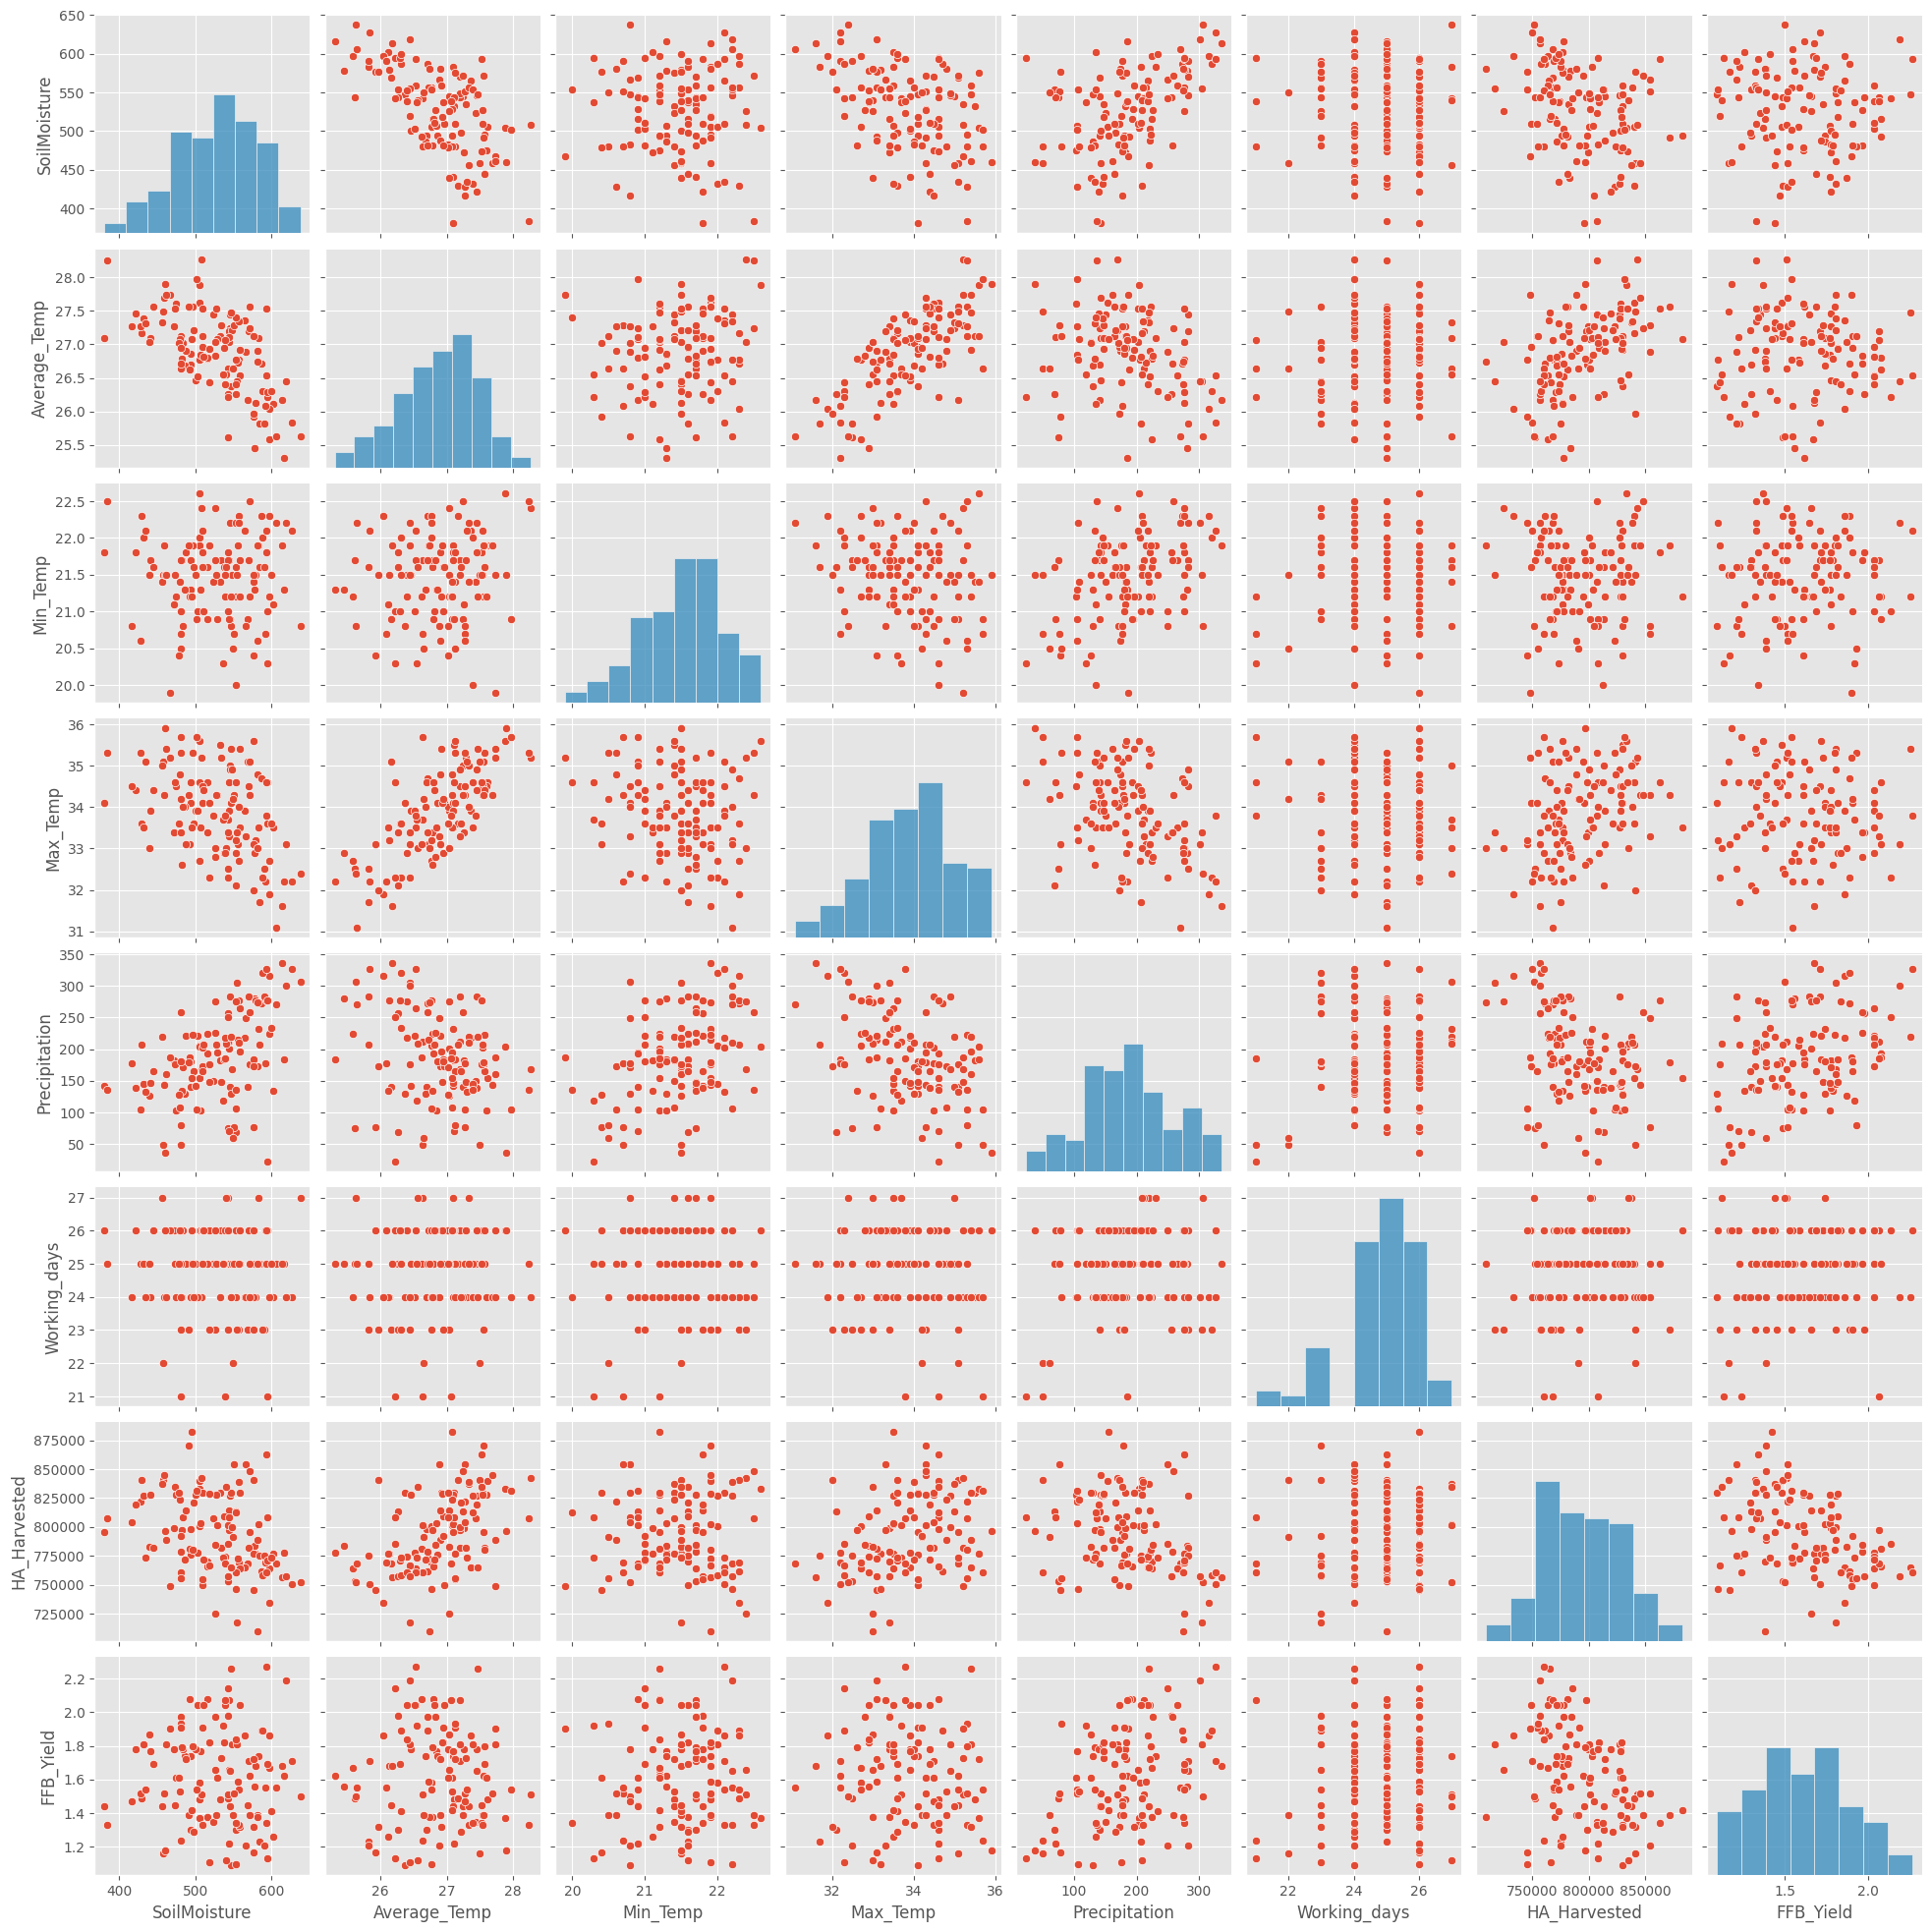

In [12]:
# Check the relationship between attributes using scatterplotmatrix
sns.pairplot(data)
plt.show()

### Summary:
According to the boxplots, we can see that average temperature, minimum temperature, precipitation, working days and HA harvested have a few outliers. Since we want to understand the general relationship between FFB yield and the external factors, we removed the outliers. Based on the histogram, we can see that all attributes are following normal distribution. Based on the correlation heatmap and scatterplotmatrix, soil moisture, average temperature, minimum temperature, maximum temperature and working days have weak or no correlation with FFB yield whereas precipitation and HA harvested have moderate correlation with FFB yield. In addition, we can see that almost all external factors have weak to moderate correlation with each other which is good because it means that there are no redundant attributes in the dataset, all attributes will contribute in different way to the FFB yield. However, we did see slightly stronger positive correlation between average and maximum temperature, meaning that these two attributes might convey the same meaning, either one can be removed from the analysis.

## D. Linear Regression

In [13]:
# Use linear regression to analyze the relationship between FFB yield and external factors
x = data.drop("FFB_Yield", axis=1)
x = sm.add_constant(x)
y = data["FFB_Yield"]
result = sm.OLS(y, x).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              FFB_Yield   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     8.181
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           4.71e-08
Time:                        09:44:35   Log-Likelihood:                 7.0630
No. Observations:                 122   AIC:                             1.874
Df Residuals:                     114   BIC:                             24.31
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.4759      1.654      2.706

### Summary:
Based on the result, we can see that the R-squared of the regression is 0.334 meaning that the model can only capture 33.4% of the variance of the data. While looking at the p-value at 95% significant level, we can see that only soil moisture, minimum temperature, precipitation and HA harvested are statistically significant in predicting FFB yield because these attributes have p-value less than 0.05. Average temperature, maximum temperature and working days have p-value greater than 0.05, so these attributes are not statistically significant in predicting FFB yield. Look closer at the coefficient of each attribute, we can explain the relationship between FFB yield and external factors as below:
- When soil moisture increase by 1mm, the FFB yield will decrease by 0.0015 tonnes
- When average temperature increase by 1 degree celsius, the FFB yield will increase by 0.0857 tonnes
- When minimum temperature increase by 1 degree celsius, the FFB yield will decrease by 0.0949 tonnes
- When maximum temperature increase by 1 degree celsius, the FFB yield will decrease by 0.0104 tonnes
- When precipitation increase by 1mm, the FFB yield will increase by 0.002 tonnes
- When working days increase by 1 day, the FFB yield will increase by 0.0143 tonnes
- When HA harvested increase by 1 hectare, the FFB yield will decrease by 3.384e-06 tonnes

## E. Decision Tree

In [14]:
# Cut the FFB yield into 4 classes
x = data.drop("FFB_Yield", axis=1)
y = pd.cut(data["FFB_Yield"], bins=4).astype(str)
print(y.value_counts(normalize=True))

(1.385, 1.68]     0.352459
(1.68, 1.975]     0.303279
(1.089, 1.385]    0.229508
(1.975, 2.27]     0.114754
Name: FFB_Yield, dtype: float64


In [15]:
# Train decision tree classifier and check f1-score
dt = DecisionTreeClassifier(max_depth=5, random_state=0, class_weight="balanced").fit(x, y)
y_pred = dt.predict(x)
print(f1_score(y, y_pred, average="macro"))

0.8097720232021548


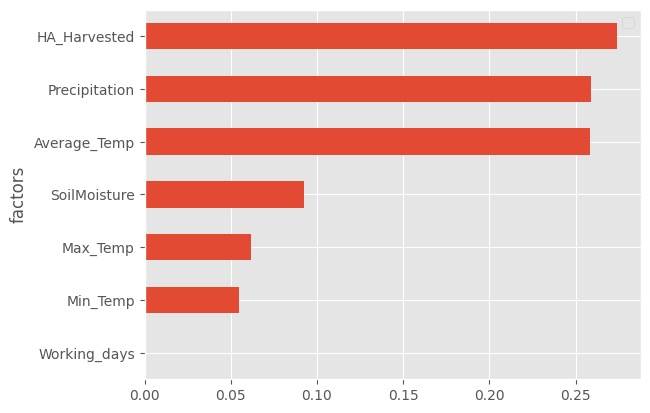

In [16]:
# Visualize feature importance using bar chart
importance = pd.DataFrame({"factors": dt.feature_names_in_, "importance": dt.feature_importances_})
importance.sort_values("importance").set_index("factors").plot(kind="barh")
plt.legend("")
plt.show()

In [17]:
# Get the important rules learned from decision tree classifier
tree_rules = export_text(dt, feature_names=list(x.columns), max_depth=5)
print(tree_rules)

|--- HA_Harvested <= 797840.50
|   |--- Average_Temp <= 26.19
|   |   |--- Average_Temp <= 25.73
|   |   |   |--- class: (1.385, 1.68]
|   |   |--- Average_Temp >  25.73
|   |   |   |--- Average_Temp <= 26.12
|   |   |   |   |--- Precipitation <= 299.65
|   |   |   |   |   |--- class: (1.089, 1.385]
|   |   |   |   |--- Precipitation >  299.65
|   |   |   |   |   |--- class: (1.68, 1.975]
|   |   |   |--- Average_Temp >  26.12
|   |   |   |   |--- Max_Temp <= 32.40
|   |   |   |   |   |--- class: (1.385, 1.68]
|   |   |   |   |--- Max_Temp >  32.40
|   |   |   |   |   |--- class: (1.385, 1.68]
|   |--- Average_Temp >  26.19
|   |   |--- Precipitation <= 184.60
|   |   |   |--- HA_Harvested <= 751865.31
|   |   |   |   |--- Max_Temp <= 33.65
|   |   |   |   |   |--- class: (1.089, 1.385]
|   |   |   |   |--- Max_Temp >  33.65
|   |   |   |   |   |--- class: (1.975, 2.27]
|   |   |   |--- HA_Harvested >  751865.31
|   |   |   |   |--- Precipitation <= 54.50
|   |   |   |   |   |--- class

### Summary:
We first cut the FFB yield into 4 classes, so we can train it using decision tree classifier and get important rules from it. The classes are imbalanced, so we will used f1-score to evaluate our model. We set the maximum depth of the decision tree to 5 to maintain explainability of the model and to avoid overfitting. Based on the result, we can see that the model achieved 81% f1-score, meaning that it can accurately predict FFB yield up to 81% using the rules learned from the dataset. The rules learned by decision tree are more reliable than the one learned by linear regression because it can fit better with the dataset.

In terms of feature importances, we can see that the most important factors that will affect the FFB yield are HA harvested, precipitation and average temperature. The soil moisture, maximum temperature and minimum temperature only have minor impact on FFB yield because soil moisture actually carries more or less the same information as precipitation while maximum and minimum temperature carries approximately the same information as the average temperature. And factor of working days is not important at all in predicting FFB yield according to decision tree. Some important rules learned by the decision tree are as follow:
- HA harvested <= 797840.50 hectares, average temperature range from 25.73 to 26.12 degree celsius, precipitation <= 299.65mm, the FBB yield will range from 1.089 to 1.385 tonnes
- HA harvested <= 797840.50 hectares, average temperature <= 25.73 degree celsius, the FBB yield will range from 1.385 to 1.68 tonnes
- HA harvested <= 797840.50 hectares, average temperature range from 25.73 to 26.12 degree celsius, precipitation > 299.65mm, the FBB yield will range from 1.68 to 1.975 tonnes
- HA harvested <= 751865.31 hectares, average temperature > 26.19 degree celsius, precipitation <= 184.6mm, maximum temperature > 33.65 degree celsius, the FBB yield will range from 1.975 to 2.27 tonnes